<a href="https://colab.research.google.com/github/Gorodecki/Projects/blob/master/EN_RU_Seq2Seq_Attention_OPUS_Corpus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Перевод текста.


> Использование seq2seq модели с вниманием на корпусе OPUS параллельного перевода



In [2]:
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, GlobalMaxPooling1D, LSTM, GRU, Bidirectional, Embedding, Input, Concatenate, Attention, Reshape, Lambda, concatenate, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from keras.regularizers import l2, l1

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import yaml
import xml.etree.ElementTree as ET

# Парсинг

In [3]:
!pip install opustools-pkg
import opustools_pkg as opus

     |████████████████████████████████| 81kB 3.3MB/s 


In [4]:
# скачиваем, распаковываем корпус и парсим в два файла, в которых количество предложений одинаково
!opus_read -s 'en' -t 'ru' -d 'Books' -w 'source.txt' 'target.txt' -wm 'moses' -q 


Alignment file /proj/nlpl/data/OPUS/Books/latest/xml/en-ru.xml.gz not found. The following files are available for downloading:

 156 KB https://object.pouta.csc.fi/OPUS-Books/v1/xml/en-ru.xml.gz
  71 MB https://object.pouta.csc.fi/OPUS-Books/v1/xml/en.zip
   3 MB https://object.pouta.csc.fi/OPUS-Books/v1/xml/ru.zip

  75 MB Total size
./Books_latest_xml_en-ru.xml.gz ... 100% of 156 KB
./Books_latest_xml_en.zip ... 100% of 71 MB
./Books_latest_xml_ru.zip ... 100% of 3 MB


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [7]:
tree = ET.parse('/content/drive/My Drive/en-ru.tmx')
root = tree.getroot()

In [8]:
# seg_ru = '{http://www.w3.org/XML/1998/namespace}lang': 'ru'
# seg_en = '{http://www.w3.org/XML/1998/namespace}lang': 'en'

In [9]:
en = []
rus = [] 
text = []
# Проходим по тегам TMX
for level_1 in root[1]:
  for level_2 in level_1:
    for seg in level_2:
        text.append(seg.text) # .text метод извлекает содержимое элемента

# Разделяем полученный текст на рус и англ
for i in range(len(text)):
  if i%2:
    rus.append(text[i])
  else: 
    en.append(text[i])

In [10]:
rus[:10], en[:10], len(text)

(['Один раз в жизни я делаю хорошее дело... И оно бесполезно.',
  'Давайте что-нибудь попробуем!',
  'Давайте что-нибудь попробуем.',
  'Мне пора идти спать.',
  'Мне нужно идти спать.',
  'Я должен ложиться спать.',
  'Сегодня 18 июня, и это день рождения Мюриэл!',
  'Мюриэл сейчас 20.',
  'Пароль «Muiriel».',
  'Я скоро вернусь.'],
 ["For once in my life I'm doing a good deed... And it is useless.",
  "Let's try something.",
  "Let's try something.",
  'I have to go to sleep.',
  'I have to go to sleep.',
  'I have to go to sleep.',
  "Today is June 18th and it is Muiriel's birthday!",
  'Muiriel is 20 now.',
  'The password is "Muiriel".',
  'I will be back soon.'],
 974384)

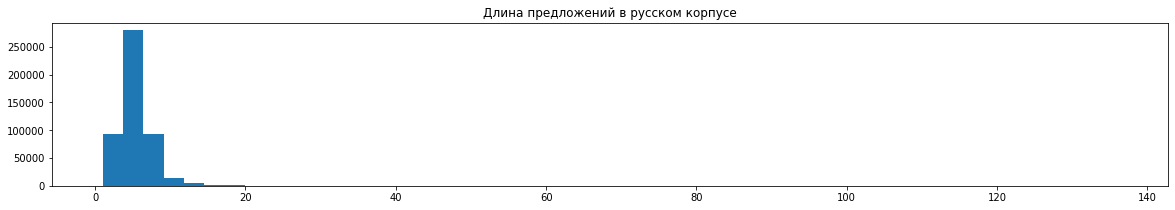

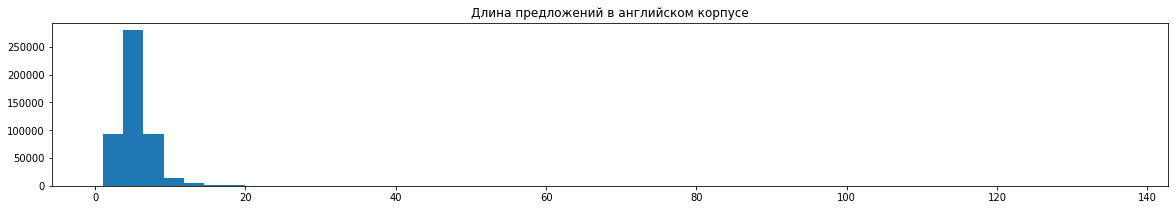

In [11]:
# Посмотрим какую выбрать длину предложения
size = []
for i in rus:
  size.append(len(i.split()))
plt.figure(figsize=(20,3))
plt.title('Длина предложений в русском корпусе')
plt.hist(size, bins=50)
plt.show()

size_ = []
for i in en:
  size_.append(len(i.split()))
plt.figure(figsize=(20,3))
plt.title('Длина предложений в английском корпусе')
plt.hist(size, bins=50)
plt.show()


In [12]:
enc_in = [q + '<END>' for q in rus]

In [13]:
enc_in[:10]

['Один раз в жизни я делаю хорошее дело... И оно бесполезно.<END>',
 'Давайте что-нибудь попробуем!<END>',
 'Давайте что-нибудь попробуем.<END>',
 'Мне пора идти спать.<END>',
 'Мне нужно идти спать.<END>',
 'Я должен ложиться спать.<END>',
 'Сегодня 18 июня, и это день рождения Мюриэл!<END>',
 'Мюриэл сейчас 20.<END>',
 'Пароль «Muiriel».<END>',
 'Я скоро вернусь.<END>']

In [14]:
decoder_in = ['<START> ' + a for a in en]
decoder_out = [a + ' <END>' for a in en]

In [15]:
decoder_in[:10]

["<START> For once in my life I'm doing a good deed... And it is useless.",
 "<START> Let's try something.",
 "<START> Let's try something.",
 '<START> I have to go to sleep.',
 '<START> I have to go to sleep.',
 '<START> I have to go to sleep.',
 "<START> Today is June 18th and it is Muiriel's birthday!",
 '<START> Muiriel is 20 now.',
 '<START> The password is "Muiriel".',
 '<START> I will be back soon.']

In [16]:
decoder_out[:10]

["For once in my life I'm doing a good deed... And it is useless. <END>",
 "Let's try something. <END>",
 "Let's try something. <END>",
 'I have to go to sleep. <END>',
 'I have to go to sleep. <END>',
 'I have to go to sleep. <END>',
 "Today is June 18th and it is Muiriel's birthday! <END>",
 'Muiriel is 20 now. <END>',
 'The password is "Muiriel". <END>',
 'I will be back soon. <END>']

In [17]:
num_words = 10000
tokenizer = Tokenizer(num_words, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', oov_token='<UNK>')

In [18]:
tokenizer.fit_on_texts(enc_in)
tokenizer.fit_on_texts(decoder_in)
tokenizer.fit_on_texts(decoder_out)

In [19]:
list(tokenizer.index_word.items())[:10]

[(1, '<UNK>'),
 (2, '<end>'),
 (3, '<start>'),
 (4, 'i'),
 (5, 'you'),
 (6, 'to'),
 (7, 'tom'),
 (8, 'the'),
 (9, 'a'),
 (10, 'я')]

In [20]:
X_enc = tokenizer.texts_to_sequences(enc_in)

In [21]:
X_dec = tokenizer.texts_to_sequences(decoder_in)
Y = tokenizer.texts_to_sequences(decoder_out)

In [22]:
# Находим длинные предложения в енкодере
threshold = 16
idx_q = [len(y) < threshold for y in X_enc]
sum(idx_q)

483489

In [23]:
X_enc = np.array(X_enc)[idx_q]
X_dec = np.array(X_dec)[idx_q]
Y = np.array(Y)[idx_q]

In [24]:
# Находим длинные предложения в декодере
idx_a = [len(y) < threshold for y in X_dec]
sum(idx_a)

480598

In [25]:
X_enc = X_enc[idx_a]
X_dec = X_dec[idx_a]
Y = Y[idx_a]

In [26]:
max_q_len = max([len(el) for el in X_enc]); max_q_len

15

In [27]:
max_a_len = max([len(el) for el in X_dec]); max_a_len

15

In [28]:
X_enc = pad_sequences(X_enc, max_q_len, padding='post', truncating='post')
X_dec = pad_sequences(X_dec, max_a_len, padding='post', truncating='post')
Y = pad_sequences(Y, max_a_len, padding='post', truncating='post')

In [29]:
print(X_enc.shape)
print(X_dec.shape)
print(Y.shape)

(480598, 15)
(480598, 15)
(480598, 15)


# Function

In [30]:
def decode_sequence(strr): 
  """
  Выводит сгенерированный ответ на вопрос.
  Подаем строку
  Возвращает строку
  """

  strr = strr + ' <end>'
  example = pad_sequences(tokenizer.texts_to_sequences([strr]), maxlen=max_q_len, padding='post')

  # возвращаем состояние [h, c]
  states_value, attention = encoder_model.predict(example)

  # создаём массив длиной pad+1
  target_token = np.zeros((1,1))
  # присваиваем первому символу "старт"
  target_token[0,0] = tokenizer.word_index['<start>']


  # флаг остановки
  Flag = False
  # обнуляем слово
  decoded_sentence = ''

  while not Flag:
    pred, *states_value = decoder_model.predict([attention, target_token] + states_value)
    
    # переводим декодированный токен в слово 
    token_pred = np.argmax(pred, axis=-1) #
    
    #print(token_pred)
    sampled_char = tokenizer.index_word[int(token_pred)]
    #print(sampled_char)
    decoded_sentence += sampled_char+' '

    # если встретили тег окончания предложения или привысили его длину
    if (sampled_char == '<end>' or len(decoded_sentence.split()) > max_a_len):
      Flag = True
      

    target_token[0,0] = token_pred

  print('Ответ:', decoded_sentence[:-6]) 

In [31]:
def pred_train(strr): 
  """
  Функция для подсчета ошибки, возвращает последовательность токенов, как в decoder_out
  """

  # возвращаем состояние [h, c]
  states_value, attention = encoder_model.predict(strr)

  # создаём массив длиной pad+1
  target_token = np.zeros((1,1))
  # присваиваем первому символу "старт"
  target_token[0,0] = tokenizer.word_index['<start>']
  # флаг остановки
  Flag = False
  # обнуляем слово
  decoded_sentence = []

  while not Flag:
    pred, *states_value = decoder_model.predict([attention, target_token] + states_value)
    
    token_pred = np.argmax(pred, axis=-1) #
    decoded_sentence.append(token_pred[0][0])

    if (token_pred == tokenizer.word_index['<end>'] or len(decoded_sentence) > max_a_len):
      Flag = True
    target_token[0,0] = token_pred
  return decoded_sentence



from tensorflow.keras.metrics import Accuracy

# Сравниваем pred и Y 
def metric(n=100, X_enc=X_enc, Y=Y, max_q_len=max_q_len):
  """
  Оценка точности, сколько верно предсказано токенов
  """

  pred = []
  summ = []
  for i in range(n):
    pred.append(pred_train(X_enc[None, i]))
  pred_1 = pad_sequences(pred, maxlen=max_q_len, padding='post')
  acc = Accuracy()
  acc.update_state(pred_1, Y[:n])
  return acc.result().numpy()

In [32]:
def att_for_plot(sentence, enc_seq_len = 15, dec_seq_len = 15): 
  """
  Функция для матрицы внимания
  sentence = строка (запрос)
  enc_seq_len = длина encoder
  dec_seq_len = длина decoder
  возвращает матрицу attention не транспонированную, строки encoder и decoder
  """

  
  attention_plot = np.zeros((enc_seq_len, dec_seq_len))

  strr = sentence + ' <end>'
  example = pad_sequences(tokenizer.texts_to_sequences([strr]), maxlen=max_q_len, padding='post')

  # возвращаем состояние [h, c]
  states_value, attention = encoder_model_.predict(example)

  # создаём массив длиной pad+1
  target_token = np.zeros((1,1))
  # присваиваем первому символу "старт"
  target_token[0,0] = tokenizer.word_index['<start>']


  # флаг остановки
  Flag = False
  # обнуляем предложение
  result = ''
  for t in range(enc_seq_len+1):
    if not Flag:
      pred, att, *states_value = decoder_model_.predict([attention, target_token] + states_value)
      

 
      attention_plot[t] = att
      # print(att)

      # переводим декодированный токен в слово 
      token_pred = np.argmax(pred, axis=-1) #
      
      #print(token_pred)
      sampled_word = tokenizer.index_word[int(token_pred)]
      result += sampled_word+' '

      # если находим тег окончания или превысили длину предложения
      if (sampled_char == '<end>' or len(result.split()) > max_a_len):
        Flag = True
        

      target_token[0,0] = token_pred
  return attention_plot, result[:-1], strr

def plot_attention(attention, sentence, predicted_sentence):
  """
  matshow attention
  """
  fig = plt.figure(figsize=(10,10))
  
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention)
  ax.set_xticklabels(sentence, rotation=90) 
  ax.set_yticklabels(predicted_sentence) 
  ax.set_xticks(np.arange(len(sentence)))
  ax.set_yticks(np.arange(len(predicted_sentence)))
  plt.show()

def plot_heatmaps(strr):
  """
  Построение матрицы внимания
  """
  attention_sentence, result, sentence = att_for_plot(strr)
  attention_plot = attention_sentence[:len(result.split(' ')), :len(sentence.split(' '))]
  print('Запрос: ', strr)
  print('Ответ:  ', result)
  # decode_sequence(strr)
  plot_attention(attention_plot.T, result.split(' '), sentence.split(' '))

#Attention

In [33]:
# Параметры
enc_seq_len = 15
dec_seq_len = 15
hidden_dim = 256
emb_size = 64

# Енкодер
encoder_input = Input((enc_seq_len,))
enc_emb = Embedding(num_words, emb_size, name='enc_emb')(encoder_input)
ys, *final_states = LSTM(hidden_dim, return_state=True, return_sequences=True, name='enc_lstm')(enc_emb)


ys_reshaped = Reshape((1, enc_seq_len, hidden_dim))(ys)
ys_repeated = Lambda(lambda l: K.repeat_elements(l, dec_seq_len, 1))(ys_reshaped)

# Декодер
decoder_input = Input((dec_seq_len,))
dec_emb = Embedding(num_words, emb_size, name='emb')(decoder_input)

dec_lstm = LSTM(hidden_dim, return_sequences=True, name='dec_lstm')(dec_emb, initial_state = final_states)

# Attention
dec_lstm_reshaped = Reshape((dec_seq_len, 1, hidden_dim))(dec_lstm)
conc = concatenate([ys_repeated, dec_lstm_reshaped], axis=-2)
conc_reshaped = Reshape((dec_seq_len, hidden_dim*(enc_seq_len+1)))(conc)

gates = Dense(enc_seq_len, activation='softmax', kernel_regularizer=l1(0.001), bias_regularizer=l1(0.001), name= 'dense_att')(conc_reshaped)
gates_reshaped = Reshape((dec_seq_len, enc_seq_len, 1))(gates)
gates_repeated = Lambda(lambda l: K.repeat_elements(l, hidden_dim, -1))(gates_reshaped)

dot_product = Lambda(lambda xy: K.sum(xy[0]*xy[1], axis=-2))([ys_repeated, gates_repeated])
attentive_state = concatenate([dec_lstm, dot_product])

# Выход
word_probabilities = Dense(num_words, activation='softmax', name= 'dense')(attentive_state)


model = Model([encoder_input, decoder_input], [word_probabilities])

In [ ]:
# Долго учится...
callback_ = EarlyStopping(monitor='val_accuracy', patience=2)
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=RMSprop(lr = 0.01))
model.fit([X_enc, X_dec], Y, epochs=5, callbacks=callback_,  batch_size=64, validation_split=0.2)

In [ ]:
# И ещё долго учится...
# model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=RMSprop(lr = 0.001))
# model.fit([X_enc, X_dec], Y, epochs=20, callbacks=callback_,  batch_size=64, validation_split=0.2)

Epoch 1/20
6008/6008 [==============================] - 262s 44ms/step - loss: 0.7806 - accuracy: 0.8658 - val_loss: 0.7694 - val_accuracy: 0.8641
Epoch 2/20
6008/6008 [==============================] - 261s 43ms/step - loss: 0.7697 - accuracy: 0.8689 - val_loss: 0.7758 - val_accuracy: 0.8637
Epoch 3/20
6008/6008 [==============================] - 261s 43ms/step - loss: 0.7703 - accuracy: 0.8700 - val_loss: 0.8075 - val_accuracy: 0.8583
Epoch 4/20
6008/6008 [==============================] - 262s 44ms/step - loss: 0.7737 - accuracy: 0.8705 - val_loss: 0.7910 - val_accuracy: 0.8633
Epoch 5/20
6008/6008 [==============================] - 262s 44ms/step - loss: 0.7758 - accuracy: 0.8709 - val_loss: 0.8076 - val_accuracy: 0.8606


In [ ]:
# Загрузим веса
# model.save('/content/drive/My Drive/attention/seq2seq_att_0.h5')
# model.save_weights('/content/drive/My Drive/attention/seq2seq_att_0_weights.h5')
# model = load_model('/content/drive/My Drive/attention/seq2seq_att_0.h5')

# Inference

In [ ]:
enc_seq_len = 15
dec_seq_len = 1 
# Input
encoder_reshaped = Input((dec_seq_len, enc_seq_len,hidden_dim,))
decoder_state_input_h = Input((hidden_dim,))
decoder_state_input_c = Input((hidden_dim,))
final_st = [decoder_state_input_h, decoder_state_input_c]
decoder_input = Input((dec_seq_len,))

# Декодер
dec_emb = Embedding(num_words, emb_size, name='emb')(decoder_input)
dec_lstm, *states_value = LSTM(hidden_dim, return_state=True, name='dec_lstm')(dec_emb, initial_state = final_st)

# attention
dec_resh = Reshape((dec_seq_len, hidden_dim))(dec_lstm)
dec_lstm_reshaped = Reshape((dec_seq_len, 1, hidden_dim))(dec_resh)
conc = concatenate([encoder_reshaped, dec_lstm_reshaped], axis=-2)
conc_reshaped = Reshape((dec_seq_len, hidden_dim*(enc_seq_len+1)))(conc)

gates = Dense(enc_seq_len, activation='softmax', name= 'dense_att')(conc_reshaped)
gates_reshaped = Reshape((dec_seq_len, enc_seq_len, 1))(gates)
gates_repeated = Lambda(lambda l: K.repeat_elements(l, hidden_dim, -1))(gates_reshaped)

dot_product = Lambda(lambda xy: K.sum(xy[0]*xy[1], axis=-2))([encoder_reshaped, gates_repeated])

attentive_state = concatenate([dec_resh, dot_product])

# Выход
word_probabilities = Dense(num_words, activation='softmax', name= 'dense')(attentive_state)

# Создаем модели
decoder_model = Model([encoder_reshaped, decoder_input]+final_st, [word_probabilities] + states_value)
encoder_model = Model(encoder_input, [final_states, ys_reshaped])

# Переносим веса
for name in ['emb', 'dec_lstm', 'dense', 'dense_att']:
  decoder_model.get_layer(name=name).set_weights(model.get_layer(name=name).get_weights())

# Если веса загружали то веса енкодера нужно тоже перенести 
for name in ['enc_emb', 'enc_lstm']:
  encoder_model.get_layer(name=name).set_weights(model.get_layer(name=name).get_weights())


In [ ]:
print('Верно предсказано токенов: ', round(metric(100)*100, 2), '%', sep='')

Верно предсказано токенов: 69.67%


In [ ]:
decode_sequence('какой вкусный пирог')

Ответ: what a cake is 


In [ ]:
for n in range(1, 50, 5):
  print('------', enc_in[n][:-5])
  decode_sequence(enc_in[n])
  print('------', decoder_out[n][:-5])
  print('-'*40)

------ Давайте что-нибудь попробуем!
Ответ: let's try something 
------ Let's try something. 
----------------------------------------
------ Сегодня 18 июня, и это день рождения Мюриэл!
Ответ: today is a <UNK> and it's a birthday it 
------ Today is June 18th and it is Muiriel's birthday! 
----------------------------------------
------ Я скоро.
Ответ: i'll be back soon 
------ I will be back soon. 
----------------------------------------
------ Не знаю, что и сказать.
Ответ: i don't know what to say 
------ I just don't know what to say. 
----------------------------------------
------ Это новая фотография?
Ответ: this is a new picture 
------ Is it a recent picture? 
----------------------------------------
------ Образование в этом мире меня разочаровывает.
Ответ: education is the wish of my health 
------ Education in this world disappoints me. 
----------------------------------------
------ Ты у меня на пути.
Ответ: you're on my way 
------ You are in my way. 
-----------------

# Матрица внимания

In [ ]:
# Инференс с матрицей attention

enc_seq_len = 15
dec_seq_len = 1 

# Input
encoder_reshaped = Input((dec_seq_len, enc_seq_len,hidden_dim,))
decoder_state_input_h = Input((hidden_dim,))
decoder_state_input_c = Input((hidden_dim,))
final_st = [decoder_state_input_h, decoder_state_input_c]
decoder_input = Input((dec_seq_len,))

# Декодер
dec_emb = Embedding(num_words, emb_size, name='emb')(decoder_input)
dec_lstm, *states_value = LSTM(hidden_dim, return_state=True, name='dec_lstm')(dec_emb, initial_state = final_st)

# Attention
dec_resh = Reshape((dec_seq_len, hidden_dim))(dec_lstm)
dec_lstm_reshaped = Reshape((dec_seq_len, 1, hidden_dim))(dec_resh)
conc = concatenate([encoder_reshaped, dec_lstm_reshaped], axis=-2)
conc_reshaped = Reshape((dec_seq_len, hidden_dim*(enc_seq_len+1)))(conc)

# Выход с Dense нужен для матрицы внимания
gates = Dense(enc_seq_len, activation='softmax', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001), name= 'dense_att')(conc_reshaped)

gates_reshaped = Reshape((dec_seq_len, enc_seq_len, 1))(gates)
gates_repeated = Lambda(lambda l: K.repeat_elements(l, hidden_dim, -1))(gates_reshaped)

dot_product = Lambda(lambda xy: K.sum(xy[0]*xy[1], axis=-2))([encoder_reshaped, gates_repeated])

attentive_state = concatenate([dec_resh, dot_product])

# Выход для inference
word_probabilities = Dense(num_words, activation='softmax', name= 'dense')(attentive_state)

# Создаем модели
decoder_model_ = Model([encoder_reshaped, decoder_input]+final_st, [word_probabilities, gates] + states_value)
encoder_model_ = Model(encoder_input, [final_states, ys_reshaped])

for name in ['emb', 'dec_lstm', 'dense', 'dense_att']:
  decoder_model_.get_layer(name=name).set_weights(model.get_layer(name=name).get_weights())
for name in ['enc_emb', 'enc_lstm']:
  encoder_model_.get_layer(name=name).set_weights(model.get_layer(name=name).get_weights())

Запрос:  Привет как дела
Ответ:   hi how are you <end>


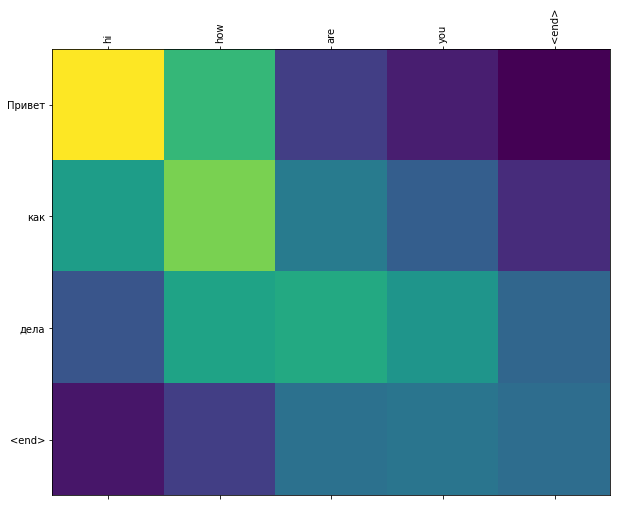

In [ ]:
# strr = 'Один раз в жизни я делаю хорошее дело... И оно бесполезно.'
strr = 'Привет как дела'
# strr = 'Образование в этом мире меня разочаровывает'
plot_heatmaps(strr)